In [2]:
# Import des bibliothèques nécessaires
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
# Chargement des données
data_path = './Human_vital_signs_R.csv'
health_data = pd.read_csv(data_path)

# Définition des plages valides
valid_hr_range = (40, 120)  # Fréquence cardiaque acceptable
valid_spo2_range = (90, 100)  # Saturation en oxygène acceptable
valid_temp_range = (36.0, 37.5)  # Température corporelle acceptable

# Application des filtres pour garder seulement les données valides
health_data = health_data[
    (health_data[' HR (BPM)'].between(*valid_hr_range)) &
    (health_data[' SpO2 (%)'].between(*valid_spo2_range)) &
    (health_data['TEMP (*C)'].between(*valid_temp_range))
]


# Vérification des noms de colonnes et suppression des colonnes inutiles
print("Colonnes initiales:", health_data.columns)
health_data.drop(['Unnamed: 0', 'Time (s)', ' RESP (BPM)'], axis=1, inplace=True)
print("Colonnes après nettoyage:", health_data.columns)




Colonnes initiales: Index(['Unnamed: 0', 'Time (s)', ' HR (BPM)', ' RESP (BPM)', ' SpO2 (%)',
       'TEMP (*C)', 'OUTPUT'],
      dtype='object')
Colonnes après nettoyage: Index([' HR (BPM)', ' SpO2 (%)', 'TEMP (*C)', 'OUTPUT'], dtype='object')


In [3]:
health_data

,HR (BPM),SpO2 (%),TEMP (*C),OUTPUT
0,94.0,97.0,36.2,Normal
1,94.0,97.0,36.2,Normal
4,93.0,95.0,37.0,Normal
265,91.0,97.0,37.0,Abnormal
270,91.0,97.0,37.0,Abnormal
...,...,...,...,...
25487,91.0,100.0,36.0,Abnormal
25489,94.0,98.0,36.4,Normal
25490,94.0,97.0,36.2,Normal
25491,93.0,95.0,37.0,Normal


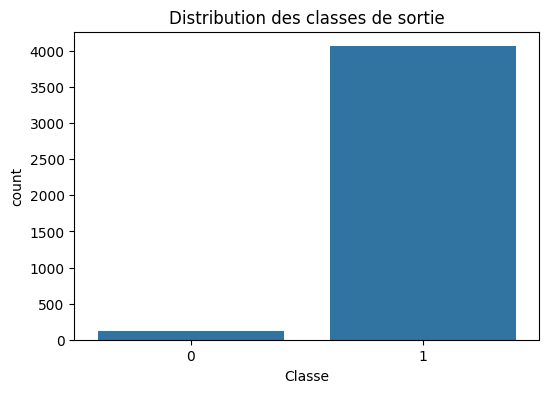

In [4]:

plt.figure(figsize=(6, 4))  # Ajustez la taille si nécessaire
sns.countplot(x='OUTPUT', data=health_data)
plt.title("Distribution des classes de sortie")
plt.xlabel('Classe')
plt.ylabel('count')
plt.xticks([0, 1], ['0', '1'])  # Ajustez les étiquettes selon vos données
plt.show()

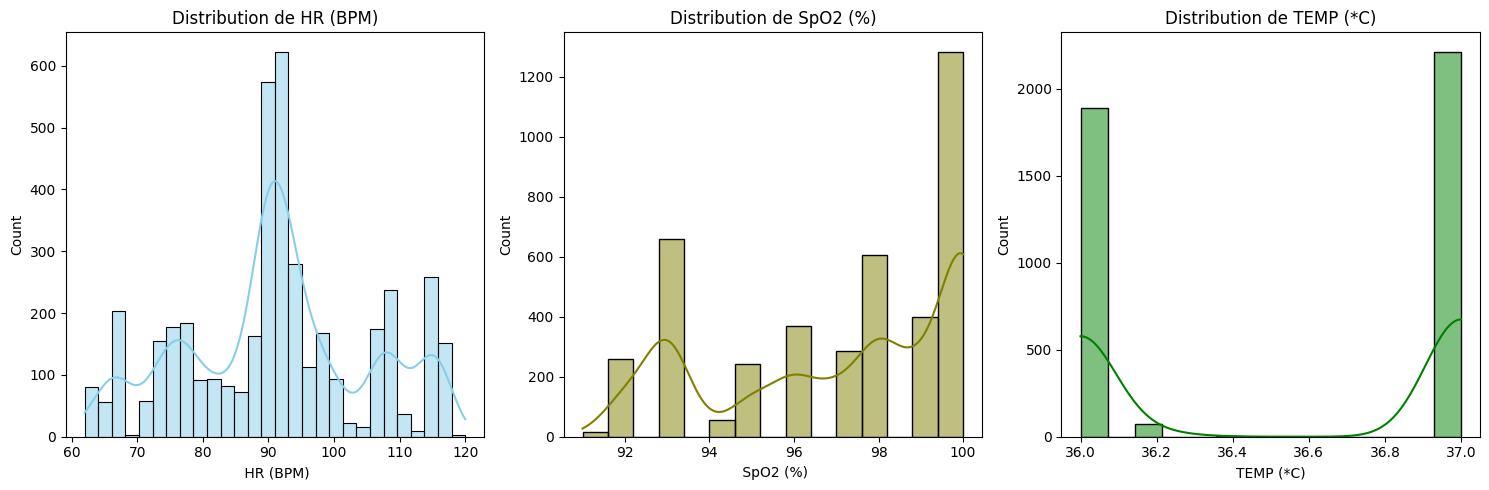

In [5]:
# Visualisation des distributions initiales de HR, SpO2, et TEMP
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
sns.histplot(health_data[' HR (BPM)'], kde=True, color="skyblue")
plt.title('Distribution de HR (BPM)')

plt.subplot(1, 3, 2)
sns.histplot(health_data[' SpO2 (%)'], kde=True, color="olive")
plt.title('Distribution de SpO2 (%)')

plt.subplot(1, 3, 3)
sns.histplot(health_data['TEMP (*C)'], kde=True, color="green")
plt.title('Distribution de TEMP (*C)')
plt.tight_layout()
plt.show()


In [6]:
# Gestion des valeurs manquantes
print("Forme initiale des données:", health_data.shape)
health_data.dropna(inplace=True)
print("Forme des données après suppression des NA:", health_data.shape)




Forme initiale des données: (4178, 4)
Forme des données après suppression des NA: (4178, 4)


C:\Users\asus\AppData\Local\Temp\ipykernel_1908\4205240237.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  health_data['OUTPUT'] = health_data['OUTPUT'].str.strip().str.lower().replace({'normal': 0, 'abnormal': 1})


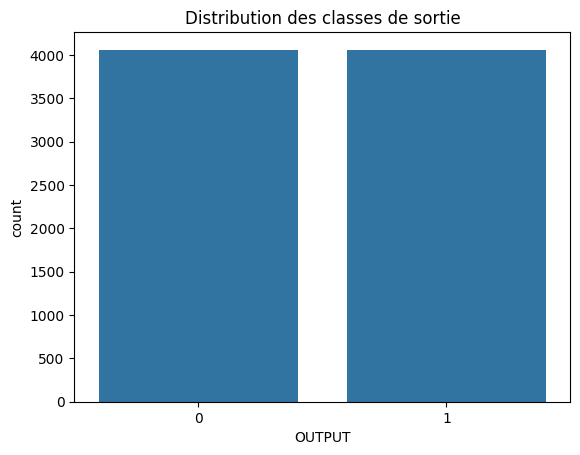

In [7]:
# Normalisation des valeurs de la colonne 'OUTPUT'
health_data['OUTPUT'] = health_data['OUTPUT'].str.strip().str.lower().replace({'normal': 0, 'abnormal': 1})

# Équilibrage des classes par suréchantillonnage
df_major = health_data[health_data['OUTPUT'] == 1]
df_minor = health_data[health_data['OUTPUT'] == 0]
df_minor_oversampled = df_minor.sample(n=len(df_major), replace=True, random_state=42)
df_balanced = pd.concat([df_major, df_minor_oversampled]).sample(frac=1, random_state=42).reset_index(drop=True)

# Affichage de la distribution des classes
plt.figure()
sns.countplot(x='OUTPUT', data=df_balanced)
plt.title("Distribution des classes de sortie")
plt.show()



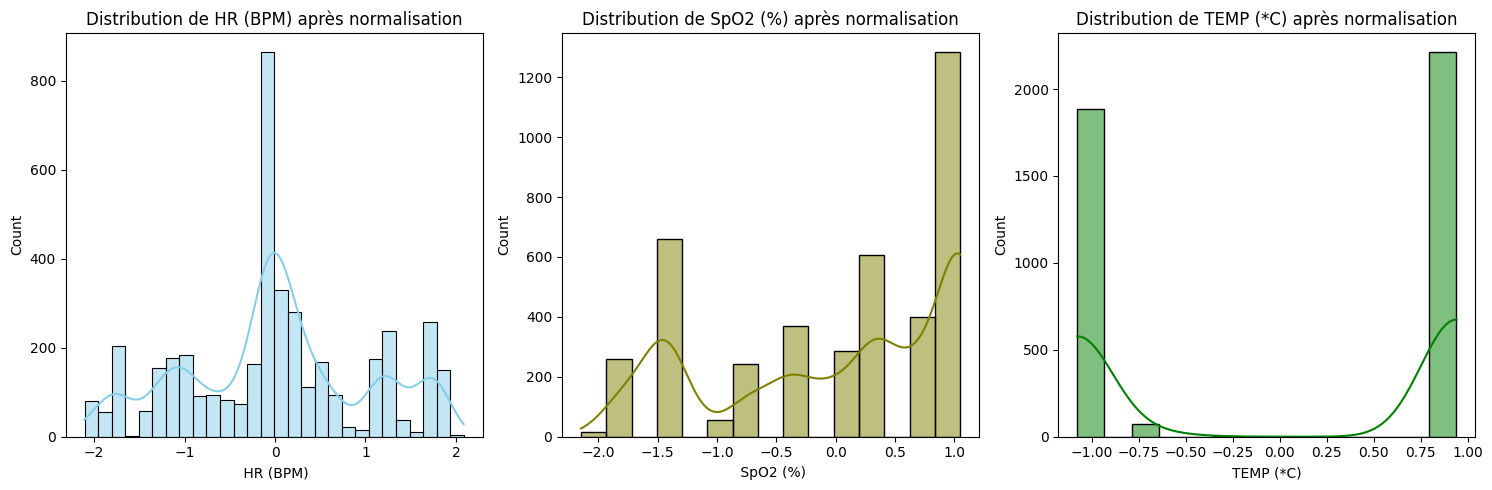

In [8]:
# Normalisation des données pour la visualisation
scaler_vis = StandardScaler()
health_data_scaled = scaler_vis.fit_transform(health_data[[' HR (BPM)', ' SpO2 (%)', 'TEMP (*C)']])
health_data_scaled_df = pd.DataFrame(health_data_scaled, columns=[' HR (BPM)', ' SpO2 (%)', 'TEMP (*C)'])

# Visualisation des distributions après normalisation
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
sns.histplot(health_data_scaled_df[' HR (BPM)'], kde=True, color="skyblue")
plt.title('Distribution de HR (BPM) après normalisation')

plt.subplot(1, 3, 2)
sns.histplot(health_data_scaled_df[' SpO2 (%)'], kde=True, color="olive")
plt.title('Distribution de SpO2 (%) après normalisation')

plt.subplot(1, 3, 3)
sns.histplot(health_data_scaled_df['TEMP (*C)'], kde=True, color="green")
plt.title('Distribution de TEMP (*C) après normalisation')
plt.tight_layout()
plt.show()


In [9]:
# Préparation des données pour l'entraînement
X = df_balanced.iloc[:,:-1]
Y = df_balanced['OUTPUT']
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

print("Taille de l'ensemble d'entraînement :", x_train.shape[0])
print("Taille de l'ensemble de test :", x_test.shape[0])


Taille de l'ensemble d'entraînement : 6499
Taille de l'ensemble de test : 1625


In [10]:

# Normalisation des données
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

In [11]:
# Fonction d'évaluation du modèle
def evaluate_model(model, x_train, y_train, x_test, y_test, model_name):
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    
    # Génération du rapport de classification
    report = classification_report(y_test, y_pred, output_dict=True)  # Sauvegarde du rapport sous forme de dictionnaire
    print(f"Évaluation du modèle: {model_name}")
    print("Rapport de classification :")
    print(classification_report(y_test, y_pred))  # Affichage du rapport en format texte
    
    # Affichage de la matrice de confusion
    print("Matrice de confusion :")
    plt.title(f'Matrice de Confusion - {model_name}')
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
    plt.show()
    
    # Affichage des métriques globales
    print("Métriques globales :")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
    print(f"Precision (moyenne pondérée): {report['weighted avg']['precision']:.2f}")
    print(f"Recall (moyenne pondérée): {report['weighted avg']['recall']:.2f}")
    print(f"F1-Score (moyenne pondérée): {report['weighted avg']['f1-score']:.2f}")
    
    # Utilisation de la validation croisée pour évaluer la généralisation du modèle
    scores_cv = cross_val_score(model, X_scaled, Y, cv=5)
    print("Scores de validation croisée :", scores_cv)
    print("Précision moyenne de CV :", np.mean(scores_cv))
    
    # Tracé de la courbe ROC
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Courbe ROC (aire = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('Taux de faux positifs')
    plt.ylabel('Taux de vrais positifs')
    plt.title(f'Courbe ROC - {model_name}')
    plt.legend(loc='lower right')
    plt.show()


Évaluation du modèle: Naive Bayes
Rapport de classification :
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       780
           1       1.00      0.97      0.98       845

    accuracy                           0.98      1625
   macro avg       0.98      0.99      0.98      1625
weighted avg       0.99      0.98      0.98      1625

Matrice de confusion :


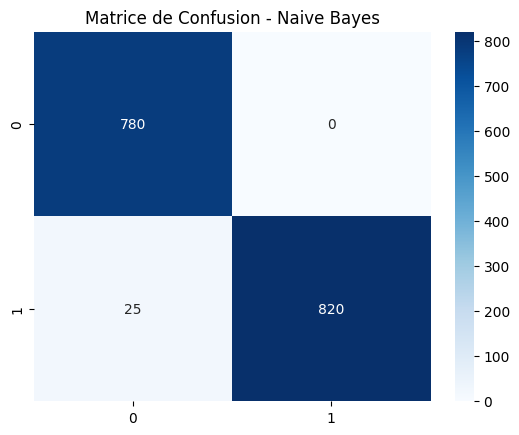

Métriques globales :
Accuracy: 0.98
Precision (moyenne pondérée): 0.99
Recall (moyenne pondérée): 0.98
F1-Score (moyenne pondérée): 0.98
Scores de validation croisée : [0.98892308 0.98461538 0.99015385 0.98892308 0.99076355]
Précision moyenne de CV : 0.9886757862826829


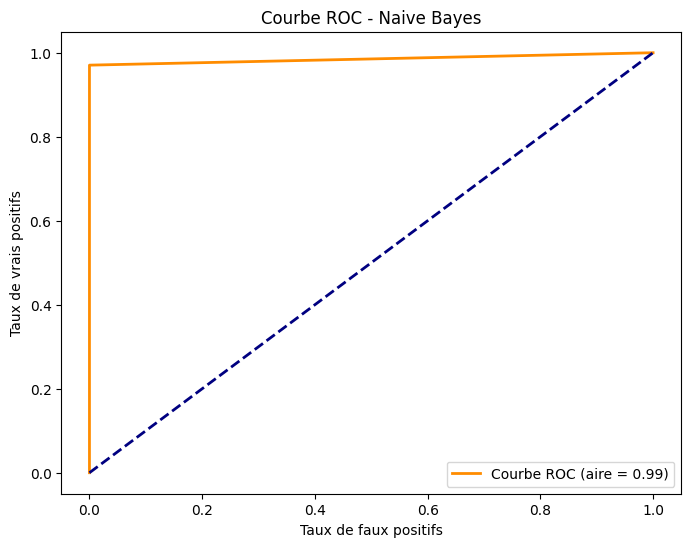

In [12]:
# # Évaluation du modèle Naive Bayes
nb_model = GaussianNB()
evaluate_model(nb_model, x_train, y_train, x_test, y_test, "Naive Bayes")

In [13]:
# from sklearn.model_selection import cross_val_score

# # Utiliser une validation croisée à 5 plis
# cv_scores = cross_val_score(nb_model, X, Y, cv=5)

# print("Scores de validation croisée : ", cv_scores)
# print("Moyenne des scores : ", np.mean(cv_scores))


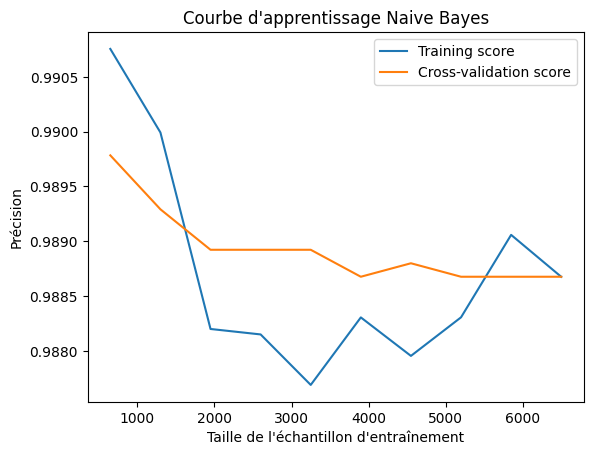

In [14]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, validation_scores = learning_curve(
    nb_model, X, Y, train_sizes=np.linspace(0.1, 1.0, 10), cv=5, scoring='accuracy')

# Calcul de la moyenne et de l'écart type des scores d'entraînement et de validation
train_scores_mean = np.mean(train_scores, axis=1)
validation_scores_mean = np.mean(validation_scores, axis=1)

# Tracé des courbes d'apprentissage
plt.plot(train_sizes, train_scores_mean, label='Training score')
plt.plot(train_sizes, validation_scores_mean, label='Cross-validation score')
plt.title('Courbe d\'apprentissage Naive Bayes')
plt.xlabel('Taille de l\'échantillon d\'entraînement')
plt.ylabel('Précision')
plt.legend()


In [15]:
# # # Exemple d'utilisation avec le modèle SVM
# svm_model = SVC(kernel='linear', random_state=42)
# evaluate_model(svm_model, x_train, y_train, x_test, y_test, "SVM")

In [16]:
# from sklearn.model_selection import learning_curve

# train_sizes, train_scores, validation_scores = learning_curve(
#     svm_model, X, Y, train_sizes=np.linspace(0.1, 1.0, 10), cv=5, scoring='accuracy')

# # Calcul de la moyenne et de l'écart type des scores d'entraînement et de validation
# train_scores_mean = np.mean(train_scores, axis=1)
# validation_scores_mean = np.mean(validation_scores, axis=1)

# # Tracé des courbes d'apprentissage
# plt.plot(train_sizes, train_scores_mean, label='Training score')
# plt.plot(train_sizes, validation_scores_mean, label='Cross-validation score')
# plt.title('Courbe d\'apprentissage SVM')
# plt.xlabel('Taille de l\'échantillon d\'entraînement')
# plt.ylabel('Précision')
# plt.legend()


In [17]:
# # Évaluation du modèle Logistic Regression
# lr_model = LogisticRegression(random_state=42)
# evaluate_model(lr_model, x_train, y_train, x_test, y_test, "Logistic Regression")

In [18]:
# from sklearn.model_selection import learning_curve

# train_sizes, train_scores, validation_scores = learning_curve(
#     lr_model, X, Y, train_sizes=np.linspace(0.1, 1.0, 10), cv=5, scoring='accuracy')

# # Calcul de la moyenne et de l'écart type des scores d'entraînement et de validation
# train_scores_mean = np.mean(train_scores, axis=1)
# validation_scores_mean = np.mean(validation_scores, axis=1)

# # Tracé des courbes d'apprentissage
# plt.plot(train_sizes, train_scores_mean, label='Training score')
# plt.plot(train_sizes, validation_scores_mean, label='Cross-validation score')
# plt.title('Courbe d\'apprentissage Logistic Regression')
# plt.xlabel('Taille de l\'échantillon d\'entraînement')
# plt.ylabel('Précision')
# plt.legend()


In [19]:
import pickle

# Supposons que `lr_model` est votre modèle de régression logistique entraîné
# Exportation du modèle au format .pkl
with open('naive_bayes_model.pkl', 'wb') as file:
    pickle.dump(nb_model, file)


In [20]:
import pickle

# Chargement du modèle
with open('naive_bayes_model.pkl', 'rb') as file:
    loaded_model = pickle.load(file)

# Utilisation du modèle chargé
# Exemple: prediction = loaded_model.predict(data)


In [54]:
# Exemple de données de test basé sur le modèle formé
test_data = [[94,97,37]]  # 72 BPM, 98% SpO2, 36.5°C


In [55]:
# Faire des prédictions avec le modèle chargé
predictions = loaded_model.predict(test_data)
print("Prédictions :", predictions)


Prédictions : [0]


c:\Python310\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but GaussianNB was fitted with feature names
  warnings.warn(
